In [1]:
%matplotlib inline
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
from PIL import Image

sys.path.append('../lib')
from local_paths import mplstyle_path, preproc_dir, stim_dir

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
# Session
save_eye_traj = False
save_psths = False

sess_name = 'Pa200515'; unit_name = '1'; save_eye_traj = True
# sess_name = 'Bo200628'; unit_name = '11'; save_psths = True


# PSTH illustration
dur_res = 100
iti_res =  50
min_dur = 200
t_pre_tr = 3000
t_post_tr = 3000
raster_max_trials = 50


# Image for illustration
example_image_name = 'a80e4aaa9bc840d1c96607e2e29e3cd5.jpg'

# Load data

In [4]:
stim_dir = Path(stim_dir).expanduser() / 'Stimuli'
proc_dir = Path(preproc_dir).expanduser()

In [5]:
proc_path = proc_dir / (sess_name + '-proc.h5')
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')
with h5.File(proc_path, 'r') as f:
    im_size = f['stimulus/size_dva'][()]

In [6]:
preproc_main_path = proc_dir / (sess_name + '-main.nwb')
with h5.File(preproc_main_path, 'r') as f:
    pres_pos = f['intervals/presentations/position'][()]
    pres_tid = list(f['intervals/presentations/trial_id'][()])
    pres_t0s = f['intervals/presentations/start_time'][()]
    pres_t1s = f['intervals/presentations/stop_time'][()]

# Scan paths illustration

In [7]:
assert example_image_name in fix_df['Image filename'].values
imn = example_image_name
im_itrs = sorted(set(fix_df[fix_df['Image filename'] == imn].index.get_level_values(0)))

print('example image:\t\t', imn)
print('num trials:\t\t', len(im_itrs))

example image:		 a80e4aaa9bc840d1c96607e2e29e3cd5.jpg
num trials:		 16


In [8]:
eye_path = Path(proc_dir) / (sess_name + '-eye_tracking.nwb')
bytr_eye_data = {}
with h5.File(eye_path, 'r') as f:
    group = f['acquisition/eye_tracking']
    for itr in im_itrs:
        dset = group[f'trial{itr}']
        bytr_eye_data[itr] = (dset['data'][()], dset['starting_time'][()]*1e3)

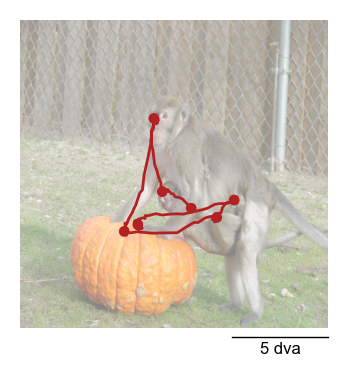

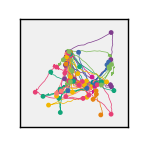

In [9]:
df_ = fix_df[fix_df['Image filename'] == imn]
pal_ = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# image
im_subdir = df_.iloc[0]['Image subdir']
im_path = stim_dir / im_subdir / imn
im = np.array(Image.open(im_path))

im_ext = np.array([[0, 0], im_size]).T  # [[left, right], [bottom, top]]
im_ext -= (im_size / 2)[:, None]

bytr_fix_xys = []  # fixations
bytr_samp_xys = []  # eye tracking samples
for ii,  itr in enumerate(im_itrs):
    df_ = fix_df.loc[(itr, slice(None)),]
    fix_xys = df_[['Relative X', 'Relative Y']].values
    eye_data, eye_data_t0 = bytr_eye_data[itr]

    # take only the period during image presentation
    t0 = df_['Time'].min()
    imax = np.argmax(df_['Time'])
    t1 = df_['Time'].values[imax] + df_['Duration'].values[imax]
    t0, t1 = (np.round([t0, t1]) - eye_data_t0).astype(int)
    samp_xys = (eye_data - pres_pos[pres_tid.index(itr)])[t0:t1].T

    bytr_fix_xys.append(fix_xys)
    bytr_samp_xys.append(samp_xys)


with plt.rc_context({
    'axes.xmargin': 0, 'axes.ymargin': 0,
    'axes.autolimit_mode': 'round_numbers', 'axes.formatter.use_mathtext': True}):

    for mode in ('one_trial', 'many_trials'):
        if mode == 'many_trials':
            fig = plt.figure(figsize=(.7,.7))
        else:
            fig = plt.figure(figsize=(2,2))
        ax = plt.gca()

        ax.set_facecolor('w')
        if mode == 'many_trials':
            ax.imshow(np.full_like(im, 225), extent=im_ext.ravel(), alpha=0.5)
            canvas_ext = im_ext
        else:
            ax.imshow(im, extent=im_ext.ravel(), alpha=0.5)
            canvas_ext = im_ext

        # fixations and traces
        for i, (fix_xys, samp_xys) in enumerate(zip(bytr_fix_xys, bytr_samp_xys)):
            if mode == 'many_trials':
                c = pal_[i % len(pal_)]
                lw = 0.25
                s = 3
            elif mode == 'one_trial':
                if i != 9:  # pick example trial
                    continue
                c = 'firebrick'
                lw = 1
                s = 15
            plt.plot(*samp_xys, lw=lw, c=c, zorder=2)
            plt.scatter(*fix_xys.T, s=s, ec='none', fc=c, zorder=3)

        ax.set_xlim(canvas_ext.ravel()[:2])
        ax.set_ylim(canvas_ext.ravel()[2:])
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        # scale bar
        if mode == 'one_trial':
            ax.spines['left'].set_visible(False)
            ax.text(s='5 dva', x=im_ext[0,1]-2.5, y=im_ext[1,0]-.75,
                    transform=ax.transData, ha='center', va='top', fontsize=6)
            ax.spines['bottom'].set_position(('data', im_ext[1,0]-.5))
            ax.spines['bottom'].set_bounds(im_ext[0,1]+[-5,0])
        else:
            [sp.set_visible(True) for sp in ax.spines.values()]

        if save_eye_traj:
            if mode == 'one_trial':
                fig.savefig('plots/fig1b.png')
            else:
                fig.savefig('plots/fig1b-inset.png')

# Spikes and PSTHs illustration

In [10]:
rasters_path = Path(proc_dir) / (sess_name + '-rasters.nwb')

with h5.File(rasters_path, 'r') as f:
    all_unit_names = list(f['processing/ecephys/unit_names/unit_name'][()].astype(str))
    iu = all_unit_names.index(unit_name)  # example unit
    rasters_u = f['processing/ecephys/rasters/data'][:,iu]

In [11]:
t0s = np.round(pres_t0s * 1e3).astype(int)  # stim onset times
rasters_tr_u = np.array([rasters_u[t-t_pre_tr:t+t_post_tr] for t in t0s[1:-1]])
print(rasters_tr_u.shape)

(1991, 6000)


In [12]:
durs = (pres_t1s - pres_t0s) * 1e3
durs = np.round(durs / dur_res) * dur_res
dur = pd.Series(durs[durs > min_dur]).mode().values.mean().item()
dur = round(dur / dur_res) * dur_res
print('Mode trial duration:\t', dur, 'ms')

itis = (pres_t0s[1:] - pres_t1s[:-1]) * 1e3
itis = np.round(itis / iti_res) * iti_res
iti = pd.Series(itis).mode().values.mean().item()
iti = np.round(iti / iti_res) * iti_res
print('Mode ITI:\t\t', iti, 'ms')  # for the record only

# these are trial ID's
itr_sel = np.array(pres_tid)[np.nonzero(durs == dur)[0]]

Mode trial duration:	 1500 ms
Mode ITI:		 1400.0 ms


In [13]:
t0_mask_tr = np.array([  # ticks to indicate stim onset times...
    np.histogram(pres_t0s*1e3, np.arange(t-t_pre_tr, t+t_post_tr+1)-.5)[0]
    for t in t0s[1:-1]])
t1_mask_tr = np.array([  # ... and stim offset times
    np.histogram(pres_t1s*1e3, np.arange(t-t_pre_tr, t+t_post_tr+1)-.5)[0]
    for t in t0s[1:-1]])

In [14]:
def rasterplot(
        ax, xs, mask,
        max_trials=raster_max_trials,
        offset=None, ax_=None, **kwargs):
    kwargs.setdefault('lw', 0.25)
    kwargs.setdefault('zorder', -1)
    if max_trials is not None:
        sel = np.random.default_rng(0).choice(len(mask), max_trials, replace=False)
        mask = mask[sel]
    v0, v1 = np.nonzero(mask[:max_trials])
    if ax_ is None:
        ax_ = plt.twinx(ax)
    if offset is not None:
        v0 += offset
    ax_.scatter(xs[v1], v0, s=1, marker='|', **kwargs)
    ax_.set_yticks([])
    return ax_

def lighten(c,k=.5):
    if isinstance(c, str):
        c = mpl.colors.hex2color(c)
    return np.array(c)*k + (1-k)

In [15]:
if save_psths:
    fig0, (ax1, ax0) = plt.subplots(2, 1, figsize=(2.2,1))
    ts = np.arange(-t_pre_tr, t_post_tr) / 1e3  # ms -> s
    m, s = rasters_tr_u.mean(0)*1e3, rasters_tr_u.std(0)*1e3  # count -> spks/s
    l, = ax0.plot(ts, m, c='k', lw=0.5)
    rasterplot(ax0, ts, rasters_tr_u, color=lighten(l.get_color()), lw=0.2, ax_=ax1)
    rasterplot(ax0, ts, t0_mask_tr, color='tab:red', lw=0.5, ax_=ax1)
    rasterplot(ax0, ts, t1_mask_tr, color='tab:pink', lw=0.5, ax_=ax1)
    ax0.set_xlabel('Time relative to image onset, s')
    ax0.set_ylabel('FR, spks/s')


    ytk = [0, 75]
    ax0.set_yticks(ytk)
    ax0.spines['left'].set_bounds(ytk)

    xtk = [-3, 0, 3]
    ax0.set_xticks([-3, 0, 3])
    ax0.tick_params(axis='y', direction='in')

    xl = [xtk[0], xtk[-1]]
    yl = ytk
    ax0.set_xlim(xl)
    ax0.set_ylim(yl)

    per = (dur + iti) / 1e3
    for i in range(int(np.floor(xl[0])/per), int(np.ceil(xl[1])/per)+1):
        t_ = i * per
        ax0.fill_betweenx(yl, t_, t_+dur/1e3, ec='none', fc='mistyrose', alpha=(.5,1)[i==0])

    ax1.set_xticks([])
    [sp.set_visible(False) for sp in ax1.spines.values()]
    ax1.set_xlim(xl)

    plt.savefig('plots/fig1f.png')